# Booking

This example uses the 'Expedia' dataset to predict, based on site activity, whether a user is likely to make a booking. You can download the Jupyter Notebook of the study <a href="booking.ipynb">here</a> and the the dataset <a href="https://www.kaggle.com/c/expedia-hotel-recommendations/data">here</a>.

<ul class="ul_content">
    <li><b>cnt: </b>Number of similar events in the context of the same user session.</li>
    <li><b>user_location_city: </b>The ID of the city in which the customer is located.</li>
    <li><b>is_package: </b>1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise.</li>
    <li><b>user_id: </b>ID of the user</li>
    <li><b>srch_children_cnt: </b>The number of (extra occupancy) children specified in the hotel room.</li>
    <li><b>channel: </b>marketing ID of a marketing channel.</li>
    <li><b>hotel_cluster: </b>ID of a hotel cluster.</li>
    <li><b>srch_destination_id: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>is_mobile: </b>1 if the user is on a mobile device, 0 otherwise.</li>
    <li><b>srch_adults_cnt: </b>The number of adults specified in the hotel room.</li>
    <li><b>user_location_country: </b>The ID of the country in which the customer is located.</li>
    <li><b>srch_destination_type_id: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>srch_rm_cnt: </b>The number of hotel rooms specified in the search.</li>
    <li><b>posa_continent: </b>ID of the continent associated with the site_name.</li>
    <li><b>srch_ci: </b>Check-in date.</li>
    <li><b>user_location_region: </b>The ID of the region in which the customer is located.</li>
    <li><b>hotel_country: </b>Hotel's country.</li>
    <li><b>srch_co: </b>Check-out date.</li>
    <li><b>is_booking: </b>1 if a booking, 0 if a click.</li>
    <li><b>orig_destination_distance: </b>Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated.</li>
    <li><b>hotel_continent: </b>Hotel continent.</li>
    <li><b>site_name: </b>ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...).</li>
</ul>

We will follow the data science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) to solve this problem.

## Initialization

This example uses the following version of VerticaPy:

In [1]:
import verticapy as vp
vp.__version__

'1.0.1'

Connect to Vertica. This example uses an existing connection called "VerticaDSN." For details on how to create a connection, use see the <a href="https://www.vertica.com/python/documentation/1.0.x/html/connection.html">connection tutorial</a>.

You can skip the below cell if you already have an established connection.

In [2]:
vp.connect("VerticaDSN")

Let's create a Virtual DataFrame of the dataset.

,📅date_timeTimestamp(29),123site_nameInteger,123posa_continentInteger,123user_location_countryInteger,123user_location_regionInteger,123user_location_cityInteger,123orig_destination_distanceNumeric(13),123user_idInteger,123is_mobileInteger,123is_packageInteger,123channelInteger,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInteger,123srch_children_cntInteger,123srch_rm_cntInteger,123srch_destination_idInteger,123srch_destination_type_idInteger,123is_bookingInteger,123cntInteger,123hotel_continentInteger,123hotel_countryInteger,123hotel_marketInteger,123hotel_clusterInteger
1,2013-12-08 18:40:27,2,3,66,351,8978,1959.332,551277,0,0,9,2013-12-29,2013-12-30,2,1,1,12132,1,0,1,2,50,366,59
2,2013-12-08 18:40:28,2,3,66,258,42500,4681.1073,433321,0,0,9,2014-02-21,2014-02-23,3,0,1,8785,1,0,2,6,105,35,78
3,2013-12-08 18:40:36,2,3,194,38,42328,[null],320963,0,0,9,2013-12-24,2013-12-28,3,0,2,1725,1,0,1,3,182,1493,86
4,2013-12-08 18:40:47,24,2,3,64,3169,[null],935710,0,0,1,2014-06-06,2014-06-08,2,0,1,4992,1,0,2,3,110,72,94
5,2013-12-08 18:40:50,11,3,205,135,27655,4443.1902,844756,0,0,0,2014-08-29,2014-08-31,4,0,2,8745,1,0,1,6,204,27,2

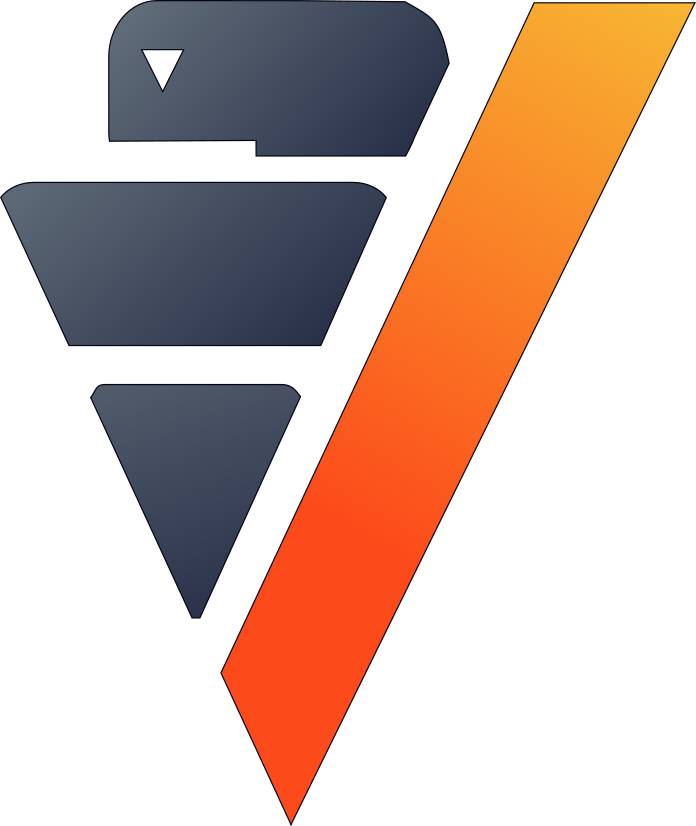

In [2]:
expedia = vp.read_csv('expedia.csv', parse_nrows=1000)
expedia.head(5)

## Data Exploration and Preparation

Sessionization is the process of gathering clicks for a certain period of time. We usually consider that after 30 minutes of inactivity, the user session ends (date_time - lag(date_time) > 30 minutes). For these kinds of use cases, aggregating sessions with meaningful statistics is the key for making accurate predictions.

We start by using the sessionize' method to create the variable 'session_id. We can then use this variable to aggregate the data.

,📅date_timeTimestamp(29),123site_nameInteger,123posa_continentInteger,123user_location_countryInteger,123user_location_regionInteger,123user_location_cityInteger,123orig_destination_distanceNumeric(13),123user_idInteger,123is_mobileInteger,123is_packageInteger,123channelInteger,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInteger,123srch_children_cntInteger,123srch_rm_cntInteger,123srch_destination_idInteger,123srch_destination_type_idInteger,123is_bookingInteger,123cntInteger,123hotel_continentInteger,123hotel_countryInteger,123hotel_marketInteger,123hotel_clusterInteger,123session_idInteger
1,2014-09-12 23:11:45,2,3,66,174,28782,2366.3264,15,1,1,2,2014-10-15,2014-10-18,2,0,1,8791,1,0,2,4,8,110,40,0
2,2014-11-14 12:50:33,2,3,66,174,41209,190.9165,15,1,0,2,2015-05-08,2015-05-10,2,0,1,11835,1,0,1,2,50,633,54,1
3,2014-11-17 14:04:53,2,3,66,174,17529,364.5643,15,1,0,9,2015-03-06,2015-03-08,2,0,1,8837,1,0,1,2,50,360,42,2
4,2014-11-18 10:38:06,2,3,66,174,26232,184.2075,15,1,0,2,2015-05-08,2015-05-10,2,0,1,11835,1,0,1,2,50,633,54,3
5,2014-11-19 09:25:32,2,3,66,174,41209,190.9165,15,1,0,2,2015-05-08,2015-05-10,2,0,1,11835,1,0,2,2,50,633,54,4
6,2014-11-21 07:57:35,2,3,66,174,29398,7146.5761,15,1,0,2,2015-01-26,2015-01-30,1,0,1,8242,1,0,1,3,171,61,49,5
7,2014-11-21 14:26:47,2,3,66,174,29398,303.776,15,1,0,2,2015-04-17,2015-04-20,2,0,1,11835,1,0,3,2,50,633,54,6
8,2014-11-21 14:28:19,2,3,66,174,29398,303.5246,15,1,0,2,2015-04-17,2015-04-20,2,0,1,11835,1,0,2,2,50,633,17,6
9,2014-11-24 14:19:54,2,3,66,174,26232,184.9901,15,1,0,2,2015-04-17,2015-04-20,2,0,1,11835,1,0,1,2,50,633,54,7
10,2014-11-24 14:20:43,2,3,66,174,26232,185.0102,15,1,0,2,2015-04-17,2015-04-20,2,0,1,11835,1,0,1,2,50,633,17,7

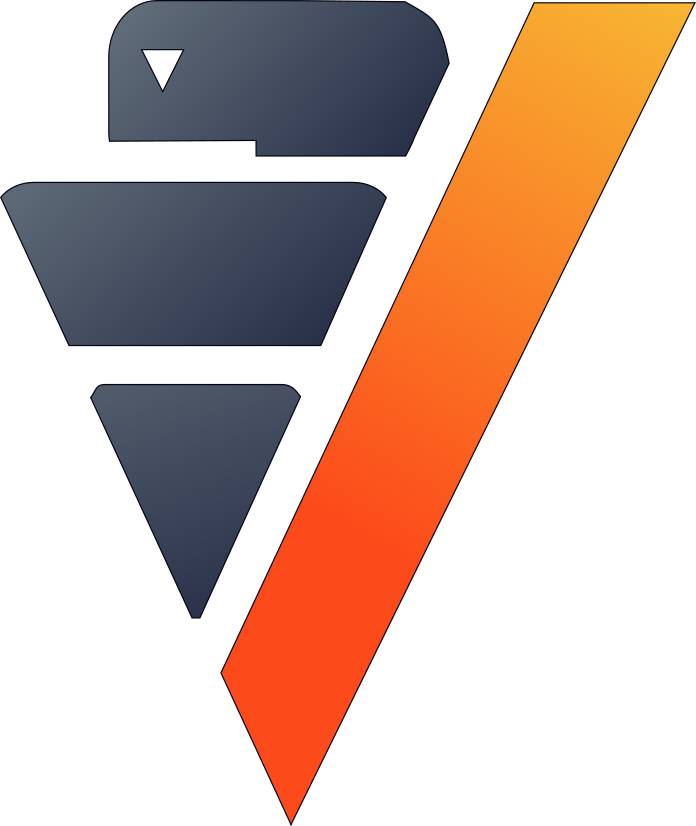

In [3]:
expedia.sessionize(ts = "date_time", 
                   by = ["user_id"], 
                   session_threshold = "30 minutes", 
                   name = "session_id")

The duration of the trip should also influence/be indicative of the user's behavior on the site, so we'll take that into account.

In [4]:
expedia["trip_duration"] = expedia["srch_co"] - expedia["srch_ci"]

If a user looks at the same hotel several times, then it might mean that they're looking to book that hotel during the session.

,📅date_timeTimestamp(29),123site_nameInteger,123posa_continentInteger,123user_location_countryInteger,123user_location_regionInteger,123user_location_cityInteger,123orig_destination_distanceNumeric(13),123user_idInteger,123is_mobileInteger,123is_packageInteger,123channelInteger,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInteger,123srch_children_cntInteger,123srch_rm_cntInteger,123srch_destination_idInteger,123srch_destination_type_idInteger,123is_bookingInteger,123cntInteger,123hotel_continentInteger,123hotel_countryInteger,123hotel_marketInteger,123hotel_clusterInteger,123session_idInteger,123trip_durationInteger,123mode_hotel_clusterInteger,123mode_hotel_cluster_countInteger
1,2014-04-25 16:14:46,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,5,1,2,62881,4,0,1,4,98,2052,20,0,2,20,3
2,2014-04-25 16:15:11,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,3,1,2,62881,4,0,1,4,98,2052,20,0,2,20,3
3,2014-04-25 16:15:50,2,3,66,174,37449,5405.7409,1,1,0,2,2014-11-07,2014-11-09,3,1,2,62881,4,0,1,4,98,2052,60,0,2,20,3
4,2014-04-25 16:14:28,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,3,1,1,62881,4,0,1,4,98,2052,20,0,2,20,3
5,2014-08-29 16:53:11,2,3,66,258,45545,1318.4152,4,0,0,7,2015-01-30,2015-02-03,6,0,1,8250,1,0,1,2,50,628,71,1,4,71,3
6,2014-08-29 16:54:16,2,3,66,258,45545,1318.8177,4,0,0,7,2015-01-30,2015-02-03,6,0,1,8250,1,0,1,2,50,628,71,1,4,71,3
7,2014-08-29 16:55:21,2,3,66,258,45545,1319.0022,4,0,0,7,2015-01-30,2015-02-03,6,0,1,8250,1,0,1,2,50,628,38,1,4,71,3
8,2014-08-29 17:00:33,2,3,66,258,45545,1317.3999,4,0,0,7,2015-01-30,2015-02-03,2,0,1,8250,1,0,1,2,50,628,18,1,4,71,3
9,2014-08-29 16:58:41,2,3,66,258,45545,1318.1384,4,0,0,7,2015-01-30,2015-02-03,2,0,1,8250,1,0,1,2,50,628,34,1,4,71,3
10,2014-08-29 16:59:41,2,3,66,258,45545,1321.0614,4,0,0,7,2015-01-30,2015-02-03,2,0,1,8250,1,0,1,2,50,628,71,1,4,71,3

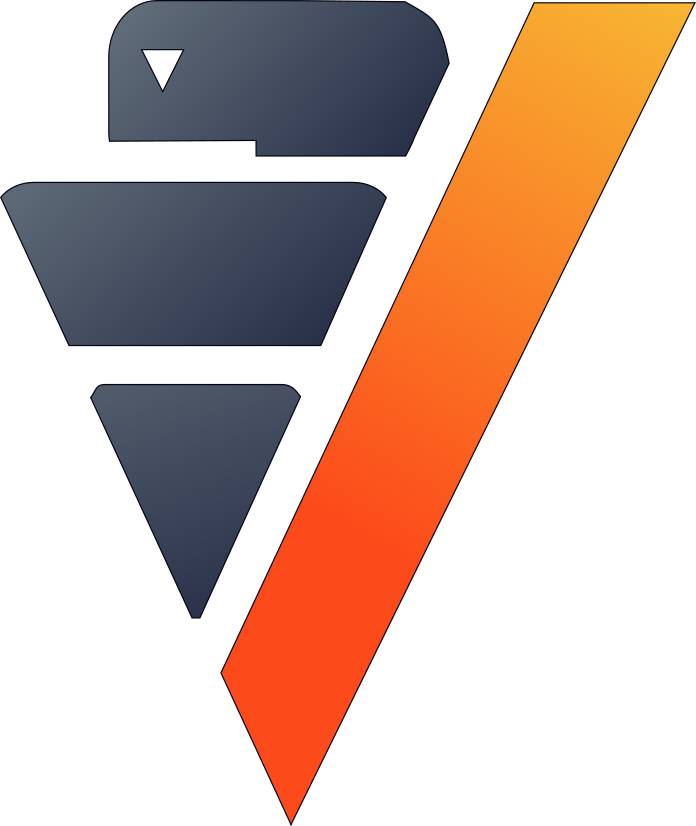

In [5]:
expedia.analytic('mode', 
                 columns = "hotel_cluster", 
                 by = ["user_id",
                       "session_id"], 
                 name = "mode_hotel_cluster",
                 add_count = True)

We can now aggregate the session and get some useful statistics out of it:
<ul class="ul_content">
    <li><b>end_session_date_time :</b> Date and time when the session ends.</li>
    <li><b>session_duration :</b> Session duration.</li>
    <li><b>is_booking :</b> 1 if the user booked during the session, 0 otherwise.</li>
    <li><b>trip_duration :</b> Trip duration.</li>
    <li><b>orig_destination_distance :</b> Average of the physical distances between the hotels and the customer.</li>
    <li><b>srch_family_cnt :</b> The number of people specified in the hotel room.</li>
</ul>

In [6]:
import verticapy.sql.functions as st
expedia = expedia.groupby(
      columns = ["user_id",
                 "session_id", 
                 "mode_hotel_cluster_count"], 
      expr = [st.max(expedia["date_time"])._as("end_session_date_time"),
              ((st.max(expedia["date_time"]) - st.min(expedia["date_time"])) / st.interval("1 second"))._as(
                  "session_duration"),
              st.max(expedia["is_booking"])._as("is_booking"),
              st.avg(expedia["trip_duration"])._as("trip_duration"),
              st.avg(expedia["orig_destination_distance"])._as("avg_distance"),
              st.sum(expedia["cnt"])._as("nb_click_session"),
              st.median(expedia["srch_children_cnt"] + expedia["srch_adults_cnt"])._as("srch_family_cnt")])

Let's look at the missing values.

,count,percent
"""user_id""",3617365.0,100.0
"""session_id""",3617365.0,100.0
"""mode_hotel_cluster_count""",3617365.0,100.0
"""end_session_date_time""",3617365.0,100.0
"""session_duration""",3617365.0,100.0
"""is_booking""",3617365.0,100.0
"""nb_click_session""",3617365.0,100.0
"""srch_family_cnt""",3617365.0,100.0
"""trip_duration""",3612554.0,99.867
"""avg_distance""",2354739.0,65.095

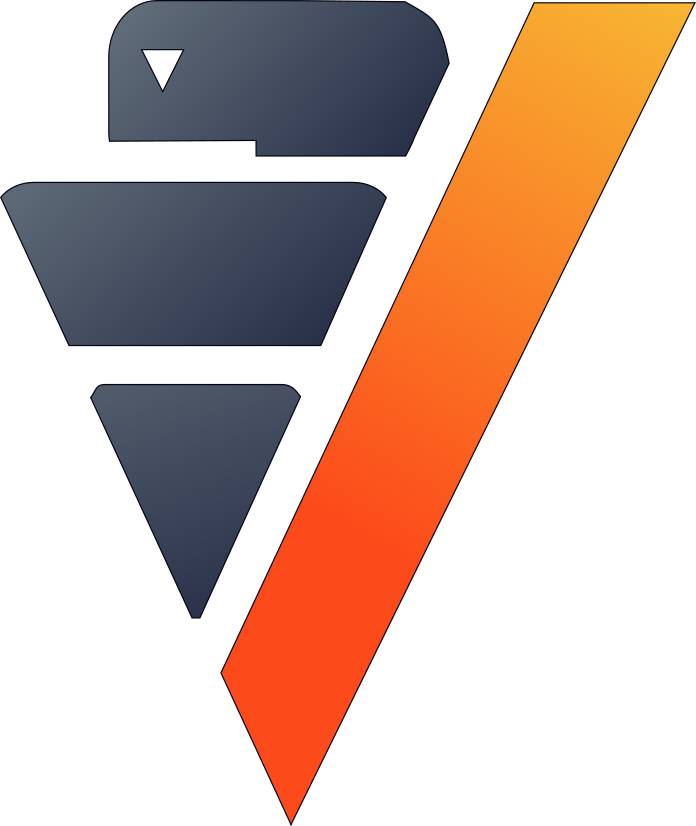

In [7]:
expedia.count_percent()

Let's impute the missing values for avg_distance and trip_duration.

1262626 elements were filled.
4811 elements were filled.


,123user_idInteger100%,123session_idInteger100%,123mode_hotel_cluster_countInteger100%,📅end_session_date_timeTimestamp(29)100%,123session_durationFloat(22)100%,123is_bookingInteger100%,123trip_durationFloat100%,123avg_distanceFloat100%,123nb_click_sessionInteger100%,123srch_family_cntFloat(22)100%
1,2,0,3,2014-01-27 13:54:07,3487.0,0,3.77777777777778,1846.04137452721,13,2.0
2,4,2,2,2014-12-07 18:25:20,414.0,0,3.33333333333333,702.0603,3,4.0
3,6,0,1,2014-07-30 17:13:07,0.0,0,3.0,836.9683,1,5.0
4,6,1,1,2014-08-28 12:03:06,534.0,0,3.0,2573.6871,2,2.0
5,6,2,1,2014-08-29 16:27:07,121.0,0,3.0,2578.36226666667,3,2.0
6,6,3,1,2014-09-01 23:58:04,97.0,0,3.0,2577.46625,3,2.0
7,6,4,1,2014-09-11 19:32:52,0.0,0,3.0,756.9031,1,2.0
8,6,5,1,2014-10-10 12:25:06,0.0,0,3.0,2759.7778,1,2.0
9,6,6,1,2014-11-03 01:01:07,0.0,0,3.0,876.1516,1,2.0
10,6,7,1,2014-11-03 11:09:56,0.0,0,1.0,2755.8182,1,2.0

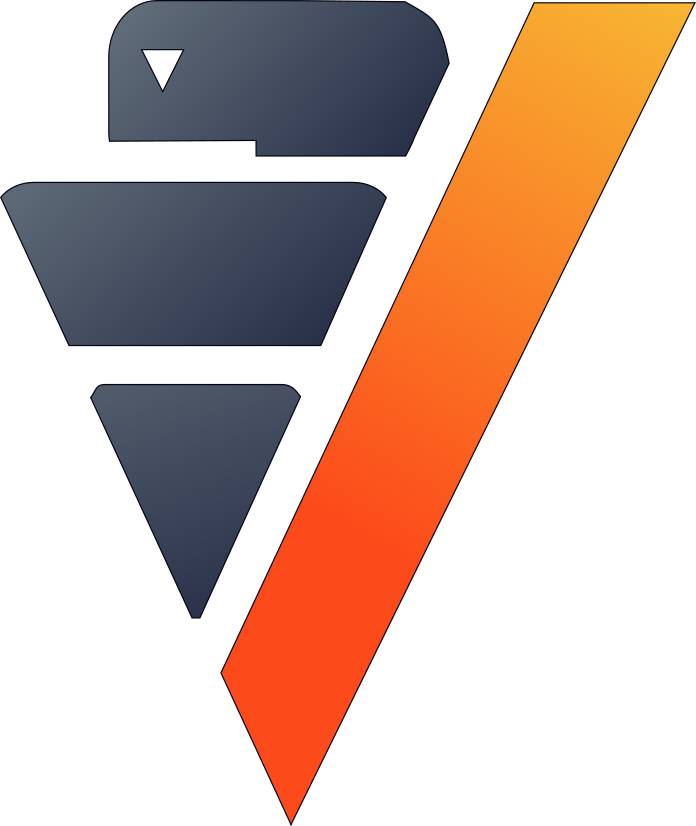

In [8]:
expedia["avg_distance" ].fillna(method = "avg")
expedia["trip_duration"].fillna(method = "avg")

We can then look at the links between the variables. We will use Spearman's rank correleation coefficient to get all the monotonic relationships.

<AxesSubplot:>

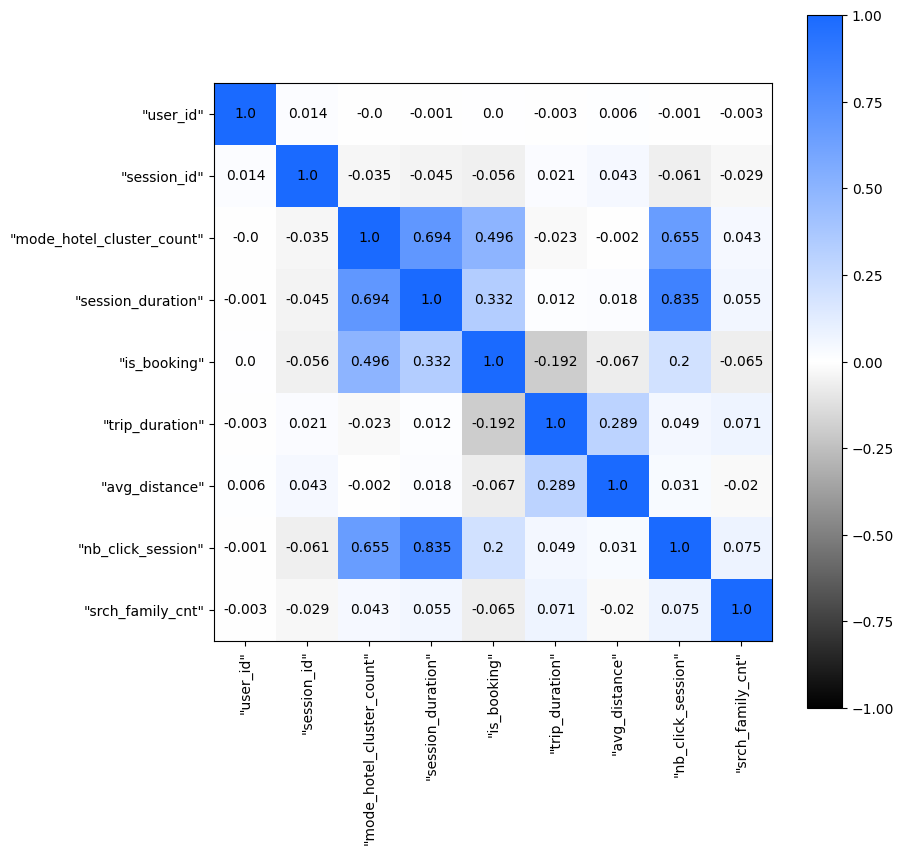

In [9]:
expedia.corr(method = "spearman")

We can see huge links between some of the variables (mode_hotel_cluster_count and session_duration) and our response variable (is_booking). A logistic regression would work well in this case because the response and predictors have a monotonic relationship.

## Machine Learning

Let's create our logistic regression model.

In [10]:
from verticapy.machine_learning.vertica import LogisticRegression
model_logit = LogisticRegression("expedia_logit", 
                                 max_iter = 1000, 
                                 solver = 'BFGS')
model_logit.fit(expedia, 
                ["avg_distance", 
                 "session_duration",
                 "nb_click_session",
                 "mode_hotel_cluster_count",
                 "session_id",
                 "srch_family_cnt",
                 "trip_duration"], 
                 "is_booking")



details
       predictor        |coefficient|std_err | z_value  |p_value 
------------------------+-----------+--------+----------+--------
       Intercept        | -1.57924  | 0.00489|-323.00526| 0.00000
      avg_distance      | -0.00004  | 0.00000|-42.58975 | 0.00000
    session_duration    |  0.00056  | 0.00000|221.97510 | 0.00000
    nb_click_session    | -0.16910  | 0.00055|-306.57894| 0.00000
mode_hotel_cluster_count|  1.13168  | 0.00217|521.85628 | 0.00000
       session_id       | -0.00552  | 0.00008|-68.90693 | 0.00000
    srch_family_cnt     | -0.21080  | 0.00163|-129.67701| 0.00000
     trip_duration      | -0.24861  | 0.00080|-311.89578| 0.00000


regularization
type| lambda 
----+--------
none| 1.00000


call_string
logistic_reg('public.expedia_logit', '"public"."_verticapy_tmp_view_v_demo_73a66912bf8811eeae050242ac120002_"', '"is_booking"', '"avg_distance", "session_duration", "nb_click_session", "mode_hotel_cluster_count", "session_id", "srch_family_cnt", "trip_durat

None of our coefficients are rejected (pvalue = 0). Let's look at their importance.

<AxesSubplot:xlabel='Importance (%)', ylabel='Features'>

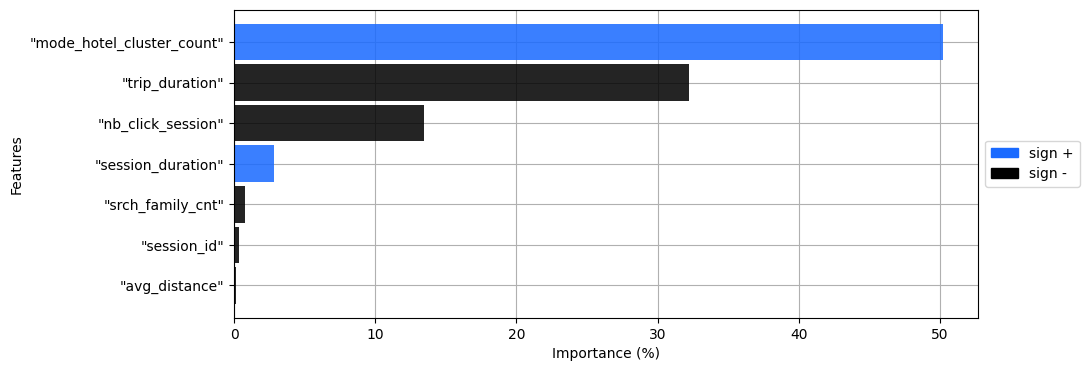

In [11]:
model_logit.features_importance()

It looks like there are two main predictors: mode_hotel_cluster_count and trip_duration. According to our model, users likely to make a booking during a particular session will tend to:

<ul class="ul_content">
    <li>look at the same hotel many times</li>
    <li>look for a shorter trip duration</li>
    <li>not click as much (spend more time at the same web page).</li>
</ul>

Let's add our prediction to the vDataFrame.

,123user_idInteger,123session_idInteger,123mode_hotel_cluster_countInteger,📅end_session_date_timeTimestamp(29),123session_durationFloat(22),123is_bookingInteger,123trip_durationFloat(22),123avg_distanceFloat(22),123nb_click_sessionInteger,123srch_family_cntFloat(22),123booking_prob_logitFloat(22)
1,2,1,2,2014-01-28 12:44:16,1454.0,0,3.0,1846.04137452721,11,2.0,0.166928199052548
2,4,0,1,2014-08-14 18:11:08,0.0,0,2.0,110.4682,1,2.0,0.17651662634086
3,12,0,1,2014-08-11 07:46:59,0.0,0,4.0,2234.2641,3,2.0,0.0783735388013165
4,15,0,1,2014-09-12 23:11:45,0.0,0,3.0,2366.3264,2,2.0,0.113801539298876
5,15,1,1,2014-11-14 12:50:33,0.0,0,2.0,190.9165,1,2.0,0.175227842184492
6,15,2,1,2014-11-17 14:04:53,0.0,0,2.0,364.5643,1,2.0,0.173385330628659
7,15,3,1,2014-11-18 10:38:06,0.0,0,2.0,184.2075,1,2.0,0.173679419168263
8,15,4,1,2014-11-19 09:25:32,0.0,0,2.0,190.9165,2,2.0,0.149991849459458
9,15,5,1,2014-11-21 07:57:35,0.0,0,4.0,7146.5761,1,1.0,0.104392334303965
10,15,6,1,2014-11-21 14:28:19,92.0,0,3.0,303.6503,5,2.0,0.0791086537930577

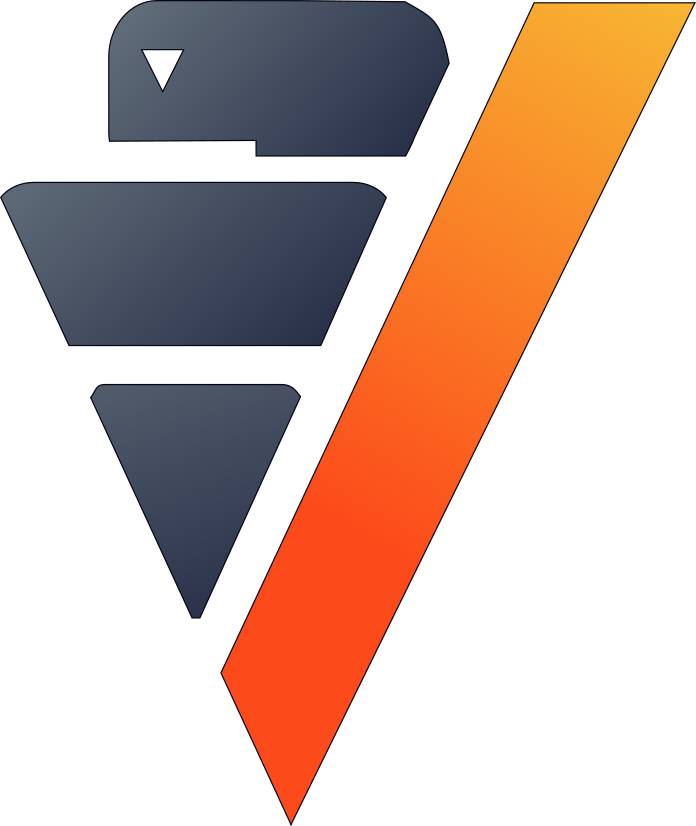

In [12]:
model_logit.predict_proba(expedia, 
                          name = "booking_prob_logit",
                          pos_label = 1)

While analyzing the following boxplot (prediction partitioned by is_booking), we can notice that the cutoff is around 0.22 because most of the positive predictions have a probability between 0.23 and 0.5. Most of the negative predictions are between 0.05 and 0.2.

/opt/venv/lib/python3.10/site-packages/verticapy/core/vdataframe/base.py:690: Warning: your vDataFrame includes duplicated names, it may be due to not assigning aliases to some columns generated by scalar operations. This can result in an unstable object. To resolve this issue, provide aliases to your queries.
  warnings.warn(warning_message, Warning)


<AxesSubplot:xlabel='is_booking', ylabel='booking_prob_logit'>

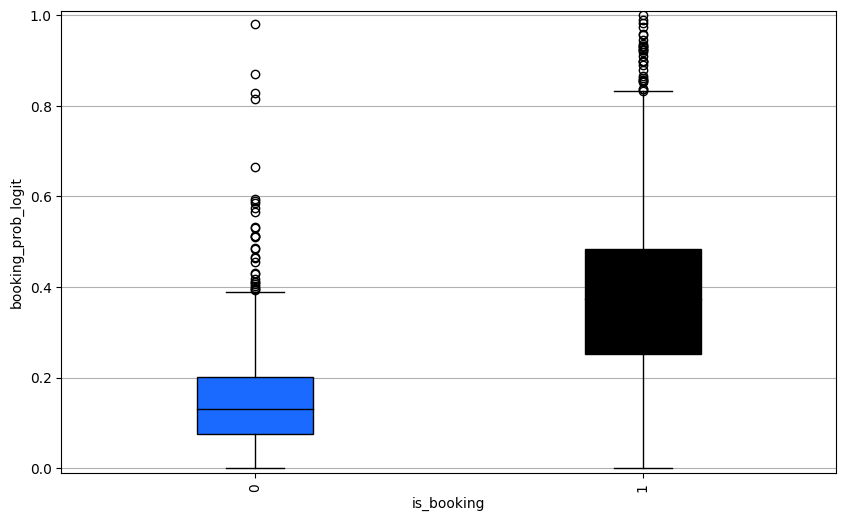

In [13]:
expedia["booking_prob_logit"].boxplot(by = "is_booking")

Let's confirm our hypothesis by computing the best cutoff.

In [17]:
model_logit.score(metric = "best_cutoff")

0.2175

Let's look at the efficiency of our model with a cutoff of 0.22.

/opt/venv/lib/python3.10/site-packages/verticapy/machine_learning/metrics/classification.py:2196: RuntimeWarning: overflow encountered in scalar multiply
  (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
/opt/venv/lib/python3.10/site-packages/verticapy/machine_learning/metrics/classification.py:2196: RuntimeWarning: invalid value encountered in sqrt
  (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


,value
auc,0.8397629418484664
prc_auc,0.5466244820070508
accuracy,0.8014112482428508
log_loss,0.182939030487669
precision,0.5292588762031176
recall,0.797623399437455
f1_score,0.6363025142012374
mcc,nan
informedness,0.6000893326691692
markedness,0.46364577547567887

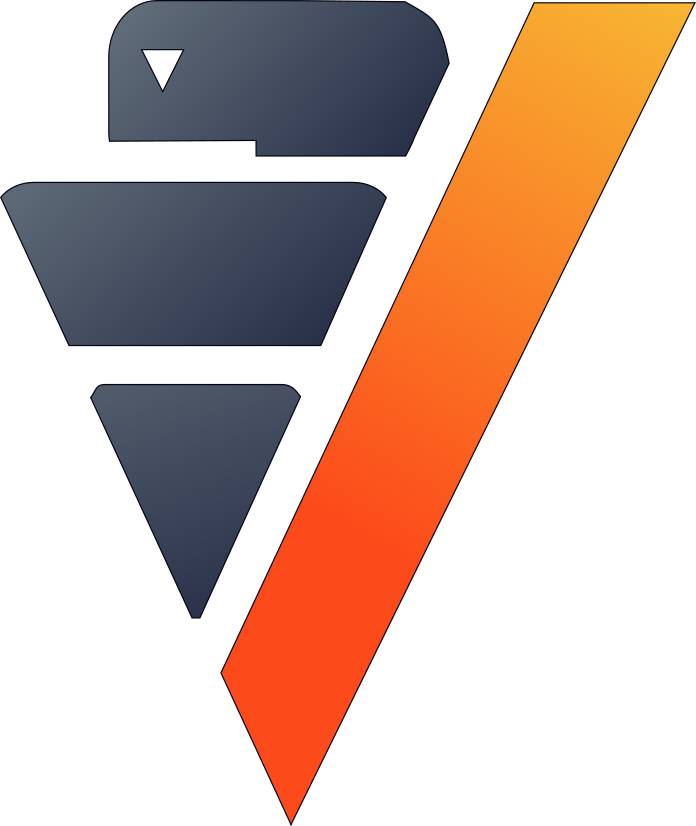

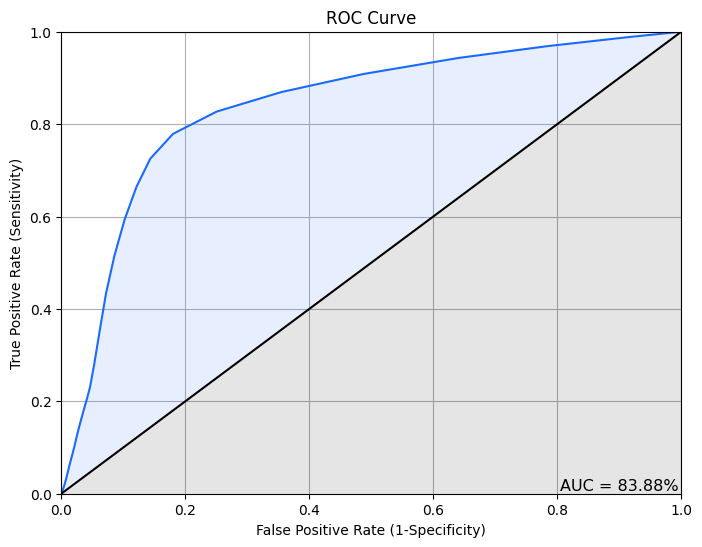

In [18]:
model_logit.roc_curve()
model_logit.report(cutoff = 0.22)

We're left with an excellent model. With this, we can predict whether a user will book a hotel during a specific session and make adjustments to our site accordingly. For example, to influence a user to make a booking, we could propose new hotels.

## Conclusion

We've solved our problem in a Pandas-like way, all without ever loading data into memory!